In [1]:
!pip install geemap

In [2]:
import hydrofunctions as hf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import folium
import geemap.foliumap as geemap
import ee
import matplotlib.dates as mdates
import hydrofns
import calendar
import pandas as pd

%matplotlib inline

In [3]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWhKtLGrUdsUbif6xMyKm0Q0k_EwbzhkvR_3kE6j9KKdU-j09HImTTk

Successfully saved authorization token.


In [12]:
# site number for NWIS gage (Pine Bluff AR Site)
pineBluff = ['07263650']

# Coordinates for the bounds of a rectangle at Pine Bluff AR
pineBluff_coord1 = [-91.75, 34.1845]
pineBluff_coord2 = [-92.1, 34.42]
pineBluff_coord3 = [-92.1973, 34.3831]
pineBluff_coord4 = [-91.83, 34.12]
pineBluff_coord5 = [-91.6933, 34.1845]

# Pine Bluff geometry
pineBluff_rectangleGeoJSON = ee.Geometry.Polygon([[
pineBluff_coord1, pineBluff_coord2, pineBluff_coord3, pineBluff_coord4, pineBluff_coord5]
]
)

pineBluff_bnds = ee.FeatureCollection([
    ee.Feature(
        pineBluff_rectangleGeoJSON,
        {'name': 'Pine Bluff, AR', 'fill': 1}),])

# Palettes for Visualization
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
waterPalette = ['red', 'yellow', 'green', 'blue']

# Import the Sentinel 2 collection as sentinel 2
sentinel2 = ee.ImageCollection(
    'COPERNICUS/S2_SR').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))

In [13]:
def get_water_pixel_count(bounds, start, end):
    """
    Add docstring here.
    """
    ndwi_threshold = 0    
    sentinel_image = sentinel2.filterBounds(
        bounds).filterDate(start, end).mosaic().clip(bounds)
    ndwi_image = sentinel_image.normalizedDifference(['B3', 'B8'])
    water_pixel_image = ndwi_image.gt(ndwi_threshold).selfMask()

    pixel_count_dict = water_pixel_image.reduceRegion(**{
        'reducer': ee.Reducer.count(),
        'geometry': bounds.geometry(),
        'scale': 10,
        'maxPixels': 1e9})
    pixel_count = pixel_count_dict.getInfo()    
    
    
    return pixel_count



In [14]:
# Need to figure out how to iterate through months with function
pb_jan = get_water_pixel_count(pineBluff_bnds, '2019-01-01', '2019-01-30')
pb_feb = get_water_pixel_count(pineBluff_bnds, '2019-02-01', '2019-02-28')
pb_mar = get_water_pixel_count(pineBluff_bnds, '2019-03-01', '2019-03-30')
pb_apr = get_water_pixel_count(pineBluff_bnds, '2019-04-01', '2019-04-30')
pb_may = get_water_pixel_count(pineBluff_bnds, '2019-05-01', '2019-05-30')
pb_jun = get_water_pixel_count(pineBluff_bnds, '2019-06-01', '2019-06-30')
#pb_jul = get_water_pixel_count(pineBluff_bnds, '2019-07-01', '2019-07-31')
pb_aug = get_water_pixel_count(pineBluff_bnds, '2019-08-01', '2019-08-30')
pb_sep = get_water_pixel_count(pineBluff_bnds, '2019-09-01', '2019-09-30')
pb_oct = get_water_pixel_count(pineBluff_bnds, '2019-10-01', '2019-10-30')
pb_nov = get_water_pixel_count(pineBluff_bnds, '2019-11-01', '2019-11-30')
pb_dec = get_water_pixel_count(pineBluff_bnds, '2019-12-01', '2019-12-31')
pb_jul = {'nd': ((pb_jun['nd'] + pb_aug['nd'])/2)}

list_pixels = [pb_jan, pb_feb, pb_mar, pb_apr, pb_may, pb_jun, pb_jul, pb_aug, pb_sep, pb_oct, pb_nov, pb_dec]

print(list_pixels)

[{'nd': 575740}, {'nd': 558534}, {'nd': 551133}, {'nd': 526333}, {'nd': 498808}, {'nd': 674053}, {'nd': 584511.0}, {'nd': 494969}, {'nd': 466796}, {'nd': 425250}, {'nd': 517616}, {'nd': 556993}]


In [15]:
# Put pixel count values for each month in a dataframe
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
df = pd.DataFrame(list_pixels, columns = ['nd'], index = months)
df

,nd
Jan,575740.0
Feb,558534.0
Mar,551133.0
Apr,526333.0
May,498808.0
June,674053.0
July,584511.0
Aug,494969.0
Sept,466796.0
Oct,425250.0


In [16]:
# Generate dataframe for hydrofunctions data
start='2019-01-01'
end='2019-12-31'
pineBluff_site_df = hydrofns.create_df_gageht(
    pineBluff, start, end)
pineBluff_site_df

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07263650&parameterCd=00065&startDT=2019-01-01&endDT=2019-12-31


,gage ht,qualifiers,sitename,latitude,longitude
datetimeUTC,,,,,
2019-01-01 00:00:00+00:00,32.89,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556
2019-01-02 00:00:00+00:00,33.81,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556
2019-01-03 00:00:00+00:00,33.68,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556
2019-01-04 00:00:00+00:00,32.66,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556
2019-01-05 00:00:00+00:00,34.68,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556
...,...,...,...,...,...
2019-12-27 00:00:00+00:00,31.45,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556
2019-12-28 00:00:00+00:00,31.23,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556
2019-12-29 00:00:00+00:00,31.40,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556


In [17]:
pineBluff_max_month_gage = pineBluff_site_df.resample('M').max()
pineBluff_max_month_gage.index = months

pineBluff_max_month_gage['pixel_count'] = df['nd']

pineBluff_max_month_gage

,gage ht,qualifiers,sitename,latitude,longitude,pixel_count
Jan,36.89,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,575740.0
Feb,36.77,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,558534.0
Mar,32.21,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,551133.0
Apr,35.47,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,526333.0
May,48.40,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,498808.0
June,50.71,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,674053.0
July,37.42,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,584511.0
Aug,32.98,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,494969.0
Sept,31.78,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,466796.0
Oct,34.84,A,"Arkansas River at Pine Bluff, AR",34.290278,-91.995556,425250.0


[Text(0.5, 0, 'Max Month Gage Height (ft)'), Text(0, 0.5, 'Water Pixel Count')]

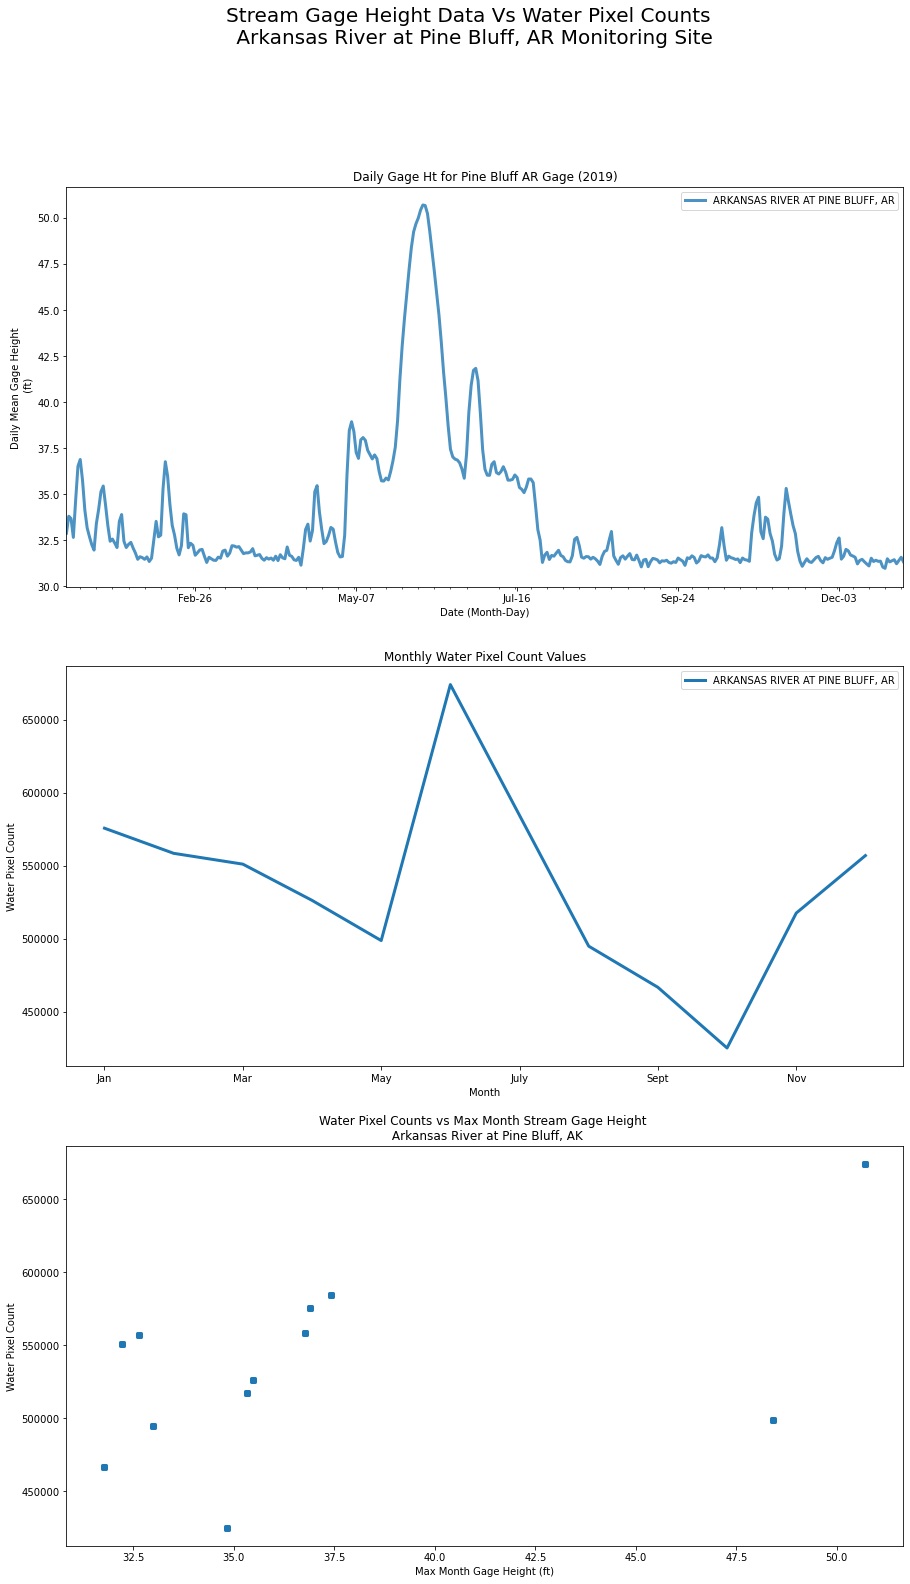

In [33]:
# Define plot space, overall size and title
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 25))

fig.suptitle(
    "Stream Gage Height Data Vs Water Pixel Counts \n Arkansas River at Pine Bluff, AR Monitoring Site", fontsize=20)

# Loop for plotting Subplot 1
pineBluff_site_df.plot(y='gage ht',
                       title="Daily Gage Ht for Pine Bluff AR Gage (2019)",
                       label='ARKANSAS RIVER AT PINE BLUFF, AR',
                       linewidth=3.0,
                       ax=ax1,
                       alpha=.8)
df.plot(y='nd',
        ax=ax2,
        title="Monthly Water Pixel Count Values",
        label="ARKANSAS RIVER AT PINE BLUFF, AR",
        linewidth=3.0)

pineBluff_max_month_gage.plot(kind='scatter',
                              x='gage ht',
                              y='pixel_count',
                              ax=ax3,
                              marker = ',',
                              linewidth=3.0,
                              title="Water Pixel Counts vs Max Month Stream Gage Height \n Arkansas River at Pine Bluff, AK")

# Define the date format for Subplot 1, set axis labels
date_form = DateFormatter("%b-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
ax1.set(xlabel="Date (Month-Day)",
        ylabel="Daily Mean Gage Height \n (ft)")
ax2.set(xlabel="Month",
        ylabel="Water Pixel Count")
ax3.set(xlabel="Max Month Gage Height (ft)",
        ylabel="Water Pixel Count")

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 11})

In [11]:
# Need to figure out how to iterate through months. (datetime package?)